/tmp/ipython-input-2854233316.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
[*********************100%***********************]  5 of 5 completed



Tail-dependence (P(i in tail | j in tail)):

           BTC    ETH  NIFTY50    DXY    TNX
BTC      0.000  0.053    0.038  0.041  0.048
ETH      0.048  0.000    0.055  0.051  0.051
NIFTY50  0.048  0.058    0.000  0.033  0.043
DXY      0.036  0.041    0.058  0.000  0.051
TNX      0.058  0.041    0.055  0.036  0.000


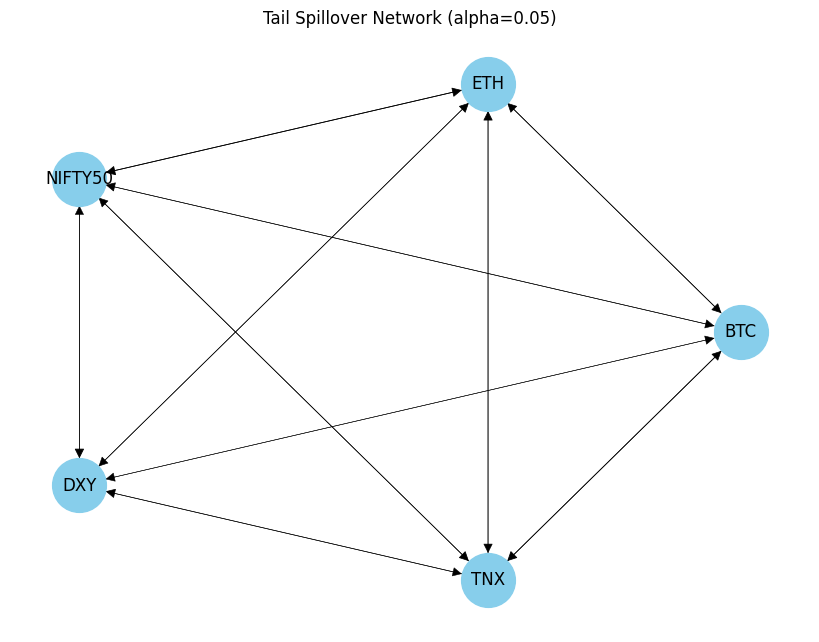

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats

# Data
tickers = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD",
    "NIFTY50": "^NSEI",
    "DXY": "UUP",
    "TNX": "^TNX"
}

data = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
data.columns = list(tickers.keys())
returns = np.log(data).diff().dropna()

#Pseudo observations
def pseudo_obs(x):
    r = stats.rankdata(x)
    return r / (len(x) + 1)

U = returns.apply(pseudo_obs)

# Fit the Copula
def fit_copula(u, v, nsim=10000, alpha=0.05):
    """Fit t-copula and estimate tail dependence."""
    u = np.clip(u, 1e-6, 1-1e-6)
    v = np.clip(v, 1e-6, 1-1e-6)
    uv = np.column_stack([u, v])

    sim = np.random.rand(nsim, 2)
    # lower-tail conditional probability
    mask_v = sim[:,1] < alpha
    if mask_v.sum() == 0:
        return 0
    cond = (sim[:,0][mask_v] < alpha).mean()
    return cond

# Tail Dependence Matric to build Spillover Network
assets = U.columns
n = len(assets)
alpha = 0.05
W = pd.DataFrame(np.zeros((n,n)), index=assets, columns=assets)

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        W.iloc[i,j] = fit_copula(U.iloc[:,i], U.iloc[:,j], alpha=alpha)

print("\nTail-dependence (P(i in tail | j in tail)):\n")
print(W.round(3))

G = nx.DiGraph()
for a in assets:
    G.add_node(a)

for i in range(n):
    for j in range(n):
        if i != j and W.iloc[i,j] > 0:
            G.add_edge(assets[j], assets[i], weight=W.iloc[i,j])

plt.figure(figsize=(8,6))
pos = nx.circular_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, with_labels=True, node_color="skyblue",
        node_size=1500, arrowsize=15,
        width=[w*10 for w in weights])
plt.title(f"Tail Spillover Network (alpha={alpha})")
plt.show()
